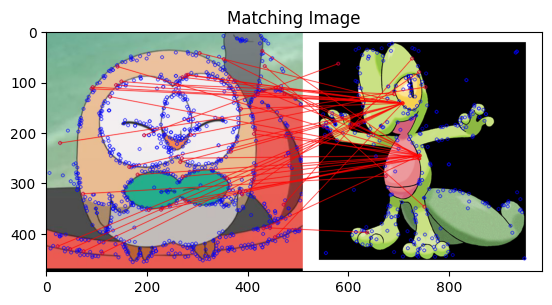

In [ ]:
import cv2  # Computer vision functions provided by OpenCV
import os  # Functions to interact with the file system
import numpy as np  # For numerical operations (used here for descriptor conversion)
import matplotlib.pyplot as plt  # For plotting the image matching results

### Step 1: Import the object image that will be used as a reference for matching.
object = cv2.imread("./Images/Object.png")  # Read the object image from file
object = cv2.cvtColor(object, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB format for correct color representation

### Step 2: Load all images from a folder that will be compared against the object image
DATA_PATH = "./Images/Data/"  # Path to the directory containing images to be matched
data = []  # Create an empty list to store the images

# Loop through the directory and load each image
for image_path in os.listdir(DATA_PATH):  # os.listdir() lists all files in the directory
    image_path = DATA_PATH + image_path  # Create the full path to the image
    image_data = cv2.imread(image_path)  # Read each image from the folder
    data.append(image_data)  # Add the image to the list

### Step 3: Preprocess the object image (convert to grayscale, blur, and equalize)
grayscale_object = cv2.cvtColor(object, cv2.COLOR_BGR2GRAY)  # Convert the object image to grayscale
grayscale_object = cv2.medianBlur(grayscale_object, 3)  # Apply a median blur to reduce noise (kernel size 3)
grayscale_object = cv2.equalizeHist(grayscale_object)  # Apply histogram equalization to improve contrast

### Step 4: Initialize the feature detection algorithms (SIFT, ORB, AKAZE)
sift = cv2.SIFT_create()  # Initialize the SIFT algorithm
orb = cv2.ORB_create()  # Initialize the ORB algorithm
akaze = cv2.AKAZE_create()  # Initialize the AKAZE algorithm

# Step 5: Detect keypoints and descriptors for the object image using SIFT
target_keypoint, target_descriptor = sift.detectAndCompute(grayscale_object, None)  # Detect keypoints and descriptors for the object image
# target_keypoint, target_descriptor = akaze.detectAndCompute(grayscale_object, None)  
# target_keypoint, target_descriptor = orb.detectAndCompute(grayscale_object, None)  

target_descriptor = np.float32(target_descriptor)  # Convert descriptors to float32 for matching with FLANN

### Step 6: Initialize variables to track the best matches
best_matches = 0  # Variable to store the number of the best matches found
best_matches_data = None  # Dictionary to store the best matching image and details

### Step 7: Loop through each image in the dataset to find matches with the object image
for index, img in enumerate(data):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display purposes
    grayscale_data = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert each dataset image to grayscale
    grayscale_data = cv2.medianBlur(grayscale_data, 3)  # Apply median blur to reduce noise
    grayscale_data = cv2.equalizeHist(grayscale_data)  # Improve contrast with histogram equalization
    img_keypoint, img_descriptor = sift.detectAndCompute(grayscale_data, None)  # Detect keypoints and compute descriptors for the dataset image
    # img_keypoint, img_descriptor = akaze.detectAndCompute(grayscale_data, None)  
    # img_keypoint, img_descriptor = orb.detectAndCompute(grayscale_data, None)  
    
    img_descriptor = np.float32(img_descriptor)  # Convert descriptors to float32 for FLANN matcher

    ### Step 8: Feature matching using FLANN-based matcher
    
    # ORB
    # flann = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    # SIFT & AKAZE
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))  # FLANN matcher with KD-tree algorithm

    matches = flann.knnMatch(target_descriptor, img_descriptor, k=2)  # K-nearest neighbor matching with k=2
    matchesmask = [[0, 0] for _ in range(0, len(matches))]  # Initialize a mask to store valid matches

    current_matches = 0  # Track the number of valid matches in the current image

    ### Step 9: Apply Lowe's ratio test to filter good matches
    for i, (fm, sm) in enumerate(matches):  # Iterate over the matches and compare the best and second-best match
        if fm.distance < 0.7 * sm.distance:  # Lowe's ratio test (distance ratio between the best and second-best match)
            matchesmask[i] = [1, 0]  # Mark this match as valid
            current_matches += 1  # Increment the number of valid matches

    ### Step 10: Track the image with the highest number of valid matches
    if current_matches > best_matches:  # If the current image has more matches than previously found
        best_matches = current_matches  # Update the best match count
        best_matches_data = {  # Store the current best matching image and details
            'image_data': img,
            'keypoint': img_keypoint,
            'descriptor': img_descriptor,
            'match': matches,
            'matchesmask': matchesmask
        }

### Step 11: Plot the results of the best match
result = cv2.drawMatchesKnn(
   object,  # The object image
   target_keypoint,  # Keypoints of the object image
   best_matches_data['image_data'],  # The best matching dataset image
   best_matches_data['keypoint'],  # Keypoints of the best matching dataset image
   best_matches_data['match'],  # The matches found between the two images
   None,  # Output image (None means it will generate a new image)
   matchesMask = best_matches_data['matchesmask'],  # Mask to highlight valid matches
   matchColor = [255, 0, 0],  # Color for matching points (red)
   singlePointColor = [0, 0, 255]  # Color for unmatched keypoints (blue)
)

### Step 12: Display the result using matplotlib
plt.figure()
plt.imshow(result)  # Show the image with matched features
plt.title("Matching Image")  # Set the title of the plot
plt.show()  # Display the plot